In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, CIFAR100

from compvit.factory import compvit_factory
from compvit.layers.attention import CrossAttention
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools


In [221]:
model, config = compvit_factory("compvits14")
model = model.to("cuda")
model.load_state_dict(torch.load("checkpoints/cifar100-56-112-224/best_performing.pt"))

head = nn.Linear(model.embed_dim, 100).to("cuda")
head.load_state_dict(torch.load("checkpoints/cifar100-56-112-224/best_performing_head.pt"))

model = model.eval()
head = head.eval()

In [222]:
TRANSFORM_TEST = tvt.Compose(
    [
        tvt.Resize(224),
        tvt.ToTensor(),
        tvt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

TRANSFORM_UNNORMED = tvt.Compose(
    [
        tvt.Resize(224),
        tvt.ToTensor(),
    ]
)

test_dataset = CIFAR100(
    "toy_experiments/data", transform=TRANSFORM_TEST, train=False, download=True
)

unnormed_dataset = CIFAR100(
    "toy_experiments/data", transform=TRANSFORM_UNNORMED, train=False, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [223]:
test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=1,
)

unnormed_loader = DataLoader(
        unnormed_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=1,
)

In [224]:
img, label = next(iter(test_loader))
img = img.to('cuda')

outputs = model.forward_features(img)
outputs = outputs["x_norm"].mean(-2)
outputs = head(outputs)
_, predicted = torch.max(outputs.data, 1)
predicted, label

(tensor([90, 33, 55, 51, 71, 54, 15, 75, 23,  0, 71, 75, 81, 69, 40, 43],
        device='cuda:0'),
 tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43]))

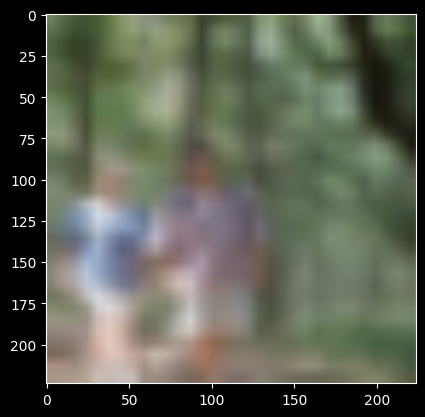

In [225]:
img_unnormed, label_unnormed = next(iter(unnormed_loader))
plt.imshow(img_unnormed[1].permute(1,2,0))

In [207]:
attn_data = {}
def attn_capture(name):
    def _attn_capture(module, input, output):
        attn_data[name] = output[1]
    return _attn_capture

In [208]:
for name, module in model.named_modules():
    if isinstance(module, CrossAttention):
        print(name, module)
        module.register_forward_hook(attn_capture(name))

compressor.block_1.attn CrossAttention(
  (q): Linear(in_features=384, out_features=384, bias=True)
  (kv): Linear(in_features=384, out_features=768, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=384, out_features=384, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
compressor.block_2.attn CrossAttention(
  (q): Linear(in_features=384, out_features=384, bias=True)
  (kv): Linear(in_features=384, out_features=768, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=384, out_features=384, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)


In [209]:
outputs = model.forward_features(img[1].unsqueeze(0), get_attn=True)
outputs = outputs["x_norm"].mean(-2)
outputs = head(outputs)
_, predicted = torch.max(outputs.data, 1)
predicted, label[1]

(tensor([33], device='cuda:0'), tensor(33))

In [219]:
attn_map_1 = attn_data['compressor.block_1.attn'].mean(1).squeeze().detach().cpu()
vals, idx = attn_map_1.topk(k=5, dim=1)

clustered = {i: set() for i in range(16)}
for i, indicies in enumerate(idx):
    clustered[i] |= set(indicies.numpy())
    print(clustered[i])
print(vals.sum(1))

{146, 163, 179, 148, 147}
{163, 195, 147, 148, 179}
{130, 163, 146, 148, 152}
{130, 163, 146, 179, 148}
{224, 241, 264, 63, 47}
{130, 146, 132, 179, 148}
{130, 163, 132, 146, 148}
{130, 163, 132, 179, 148}
{146, 163, 179, 148, 147}
{162, 163, 146, 179, 148}
{241, 227, 228, 132, 211}
{130, 163, 132, 147, 148}
{132, 260, 262, 264, 266}
{130, 163, 146, 148, 152}
{130, 131, 163, 179, 148}
{130, 163, 195, 148, 152}
tensor([0.1483, 0.1445, 0.2066, 0.1500, 0.1591, 0.1108, 0.1378, 0.0943, 0.1758,
        0.1597, 0.1341, 0.0778, 0.0441, 0.2022, 0.1869, 0.2024])


In [216]:
diff_clusters = {key: val for key, val in clustered.items()}
for i, j in list(itertools.permutations(clustered, 2)):
    diff_clusters[i] = diff_clusters[i] - clustered[j]

In [217]:
diff_clusters

{0: {120},
 1: {192},
 2: {181},
 3: {44},
 4: {1, 16, 18, 25, 40, 61, 75, 76, 90, 91, 107, 113, 128, 158, 204, 206, 207},
 5: set(),
 6: set(),
 7: set(),
 8: set(),
 9: set(),
 10: {170, 213, 247, 248, 249, 250},
 11: {59, 89},
 12: {117, 177, 217, 268},
 13: set(),
 14: {221},
 15: {255}}

In [182]:
attn_map_2 = attn_data['compressor.block_2.attn'].mean(1).squeeze().detach().cpu()
vals, idx = attn_map_2.topk(dim=1, k=100)
vals.sum(1)
vals, idx = attn_map_2.sort(dim=1, descending=True)
(vals.cumsum(dim=1) < 0.8).sum(dim=1)

tensor([127, 124,  96, 125,  84, 128, 132, 124, 106, 114,  62, 152, 128, 102,
        118, 106])

In [4]:
attn_data = torch.load("./attn_data.pth")

In [5]:
attn_data

{}

In [ ]:
model = model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in tqdm(test_loader):
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        outputs = model(images, is_training=True)
        outputs = outputs["x_norm"].mean(-2)
        outputs = head(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(correct / total)